In [477]:
from scipy.spatial.distance      import braycurtis
from IPython.display             import HTML
from Bio                         import AlignIO, SeqIO, Align, Alphabet
from copy                        import deepcopy
from statsmodels.stats.multitest import multipletests
from scipy.stats                 import hypergeom, spearmanr, mannwhitneyu

import igraph     as ig
import numpy      as np
import seaborn    as sns
import pandas     as pd
import colorlover as cl


import itertools
import multiprocessing
import random
import os
import subprocess
import re
import ete3

In [2]:
# %run ~/work/jupyter_notebooks/gene\ family\ distances/correlate_evolution.ipynb

%cd ~/work/clusterEvo/new_tests/archaea/

/nobackup1b/users/thiberio/clusterEvo/new_tests/archaea


In [3]:
ncbi         = ete3.NCBITaxa()
aln_alphabet = Alphabet.Gapped(Alphabet.IUPAC.ambiguous_dna)

In [4]:
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

In [5]:
minimum_size_groups = []
num_taxa            = pd.DataFrame( columns=['num_taxa', 
                                             'num_proteins'] )
with open('homolog_groups.list') as description:
    for line in description:
        if not line.startswith('cluster '):
            continue
        tmp_num_proteins, tmp_num_taxa = [int(count) for count in re.search('\ssize=(\d+) taxa=(\d+) file', line).groups()]
        
        if tmp_num_taxa < 10:# or tmp_num_proteins >= tmp_num_taxa * 3:
            continue
        
        tmp_name = line.split()[1]
        tmp_num  = tmp_name.split('_')[0]
        minimum_size_groups.append( tmp_name )
        
        num_taxa.loc[tmp_num] = [tmp_num_taxa, tmp_num_proteins]

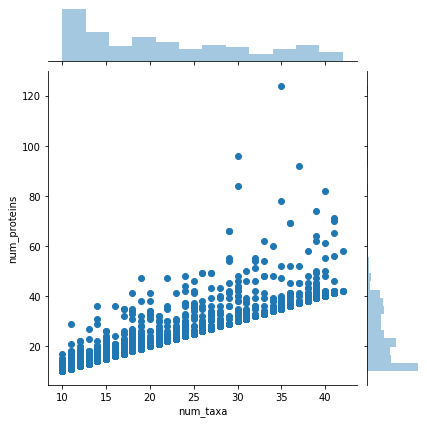

In [6]:
sns.jointplot(x=num_taxa.num_taxa, 
              y=num_taxa.num_proteins);

In [7]:
core_genes = num_taxa.query('num_taxa == num_proteins & num_taxa >= 35').index
len(core_genes)

106

In [8]:
for group_name in minimum_size_groups:
    
    group_num = group_name.split('_')[0]
    if os.path.isfile(f'minimum_size_groups/{group_num}.faa'):
        continue

    with open(f'homolog_groups/{group_name}.faa')          as  in_fasta ,\
         open(f'minimum_size_groups/{group_num}.faa', 'w') as out_fasta:
        for line in in_fasta:
            if line.startswith('>'):
                protein_id, organism_name, genome_acc = re.search('^>ID:(\S+)\s\|\[(.+?)\]\|.*?\|(GC[AF]_\d+\.\d+)', line).groups()
                out_fasta.write(f'>{protein_id}|{genome_acc}\n')
            else:
                out_fasta.write(line)

In [9]:
dist_matrices = []
group_names   = []

for group_name in minimum_size_groups:
    group_num = group_name.split('_')[0]

    try:
        tmp_matrix = pd.read_csv(f'matrices/{group_num}.mldist', 
                                  delim_whitespace = True, 
                                  skiprows         = 1, 
                                  header           = None,
                                  index_col        = 0)
    except FileNotFoundError:
        continue
    
    convert_table = {}
    for seq_name in re.findall('>(\S+)', 
                               open(f'minimum_size_groups/{group_num}.faa').read()):
        seq_name = seq_name.split('|')
        convert_table['_'.join(seq_name)] = f'{seq_name[1]}|{seq_name[0]}'
        
    tmp_matrix.rename(index  =convert_table, 
                      inplace=True)
    tmp_matrix.columns = tmp_matrix.index
    
    dist_matrices.append(tmp_matrix.copy())
    group_names.append(  group_num)
    
# table = {group:matrix.copy()
#          for group, matrix in zip(group_names, dist_matrices)}
table = dict(zip(group_names, dist_matrices))

In [10]:
%run ~/work/jupyter_notebooks/gene\ family\ distances/correlate_evolution.ipynb

assess_coevolution(dist_matrices[0].copy(), 
                   dist_matrices[1].copy(), 
                   gene_sep='|')[1]

0.41247250004393876

In [11]:
def run_coevol(matrix_pair):
    matrix1 = matrix_pair[0].copy()
    matrix2 = matrix_pair[1].copy()
    
    return(assess_coevolution(matrix1, 
                              matrix2, 
                              gene_sep='|')[1])

def get_braycurtis(matrix_pair):
    matrix1 = matrix_pair[0].copy()
    matrix2 = matrix_pair[1].copy()

    taxa1 = [taxon.split('|')[0] for taxon in matrix1.index]
    taxa2 = [taxon.split('|')[0] for taxon in matrix2.index]
    
    taxon_intersect = set(taxa1).intersection(taxa2)
    if len(taxon_intersect) < 5:
        return(None)

    freq1 = Counter(taxa1)
    freq2 = Counter(taxa2)

    freq1_input = []
    freq2_input = []
    for taxon in set(taxa1).union(taxa2):
        if taxon in freq1:
            freq1_input.append(freq1[taxon])
        else:
            freq1_input.append(0)
        if taxon in freq2:
            freq2_input.append(freq2[taxon])
        else:
            freq2_input.append(0)    
            
    return(1 - braycurtis(freq1_input, freq2_input))


In [12]:
if not os.path.isfile('coevolution_indices.tsv'):
    pool           = multiprocessing.Pool(processes=10)
    coevol_indices = pool.map(run_coevol, 
                              itertools.combinations(dist_matrices, 2))
    pool.close()
    pool.join()

    group_coevol = pd.DataFrame(columns=['group1', 'group2'],
                                data   =itertools.combinations(group_names, 2))

    group_coevol['Rsquared'] = coevol_indices


    pool               = multiprocessing.Pool(processes=10)
    braycurtis_indices = pool.map(get_braycurtis, 
                                  itertools.combinations(dist_matrices, 2))
    pool.close()
    pool.join()

    group_coevol['braycurtis'] = braycurtis_indices

    group_coevol['index'] = group_coevol['Rsquared'] * group_coevol['braycurtis']
    group_coevol.to_csv('coevolution_indices.tsv', sep='\t')
else:
    group_coevol = pd.read_csv('coevolution_indices.tsv',
                               sep='\t', 
                               index_col=0, 
                               dtype=dict(group1=str, 
                                          group2=str))

group_coevol.loc[group_coevol.Rsquared < 0, 'Rsquared'] = np.nan
group_coevol.dropna(how='any', inplace=True)

In [13]:
group_coevol.head()

,group1,group2,Rsquared,braycurtis,index
0,19,37,0.412473,0.327273,0.134991
1,19,38,0.516177,0.240000,0.123883
2,19,39,0.408034,0.301887,0.123180
3,19,47,0.553606,0.214286,0.118630
4,19,48,0.635990,0.261905,0.166569


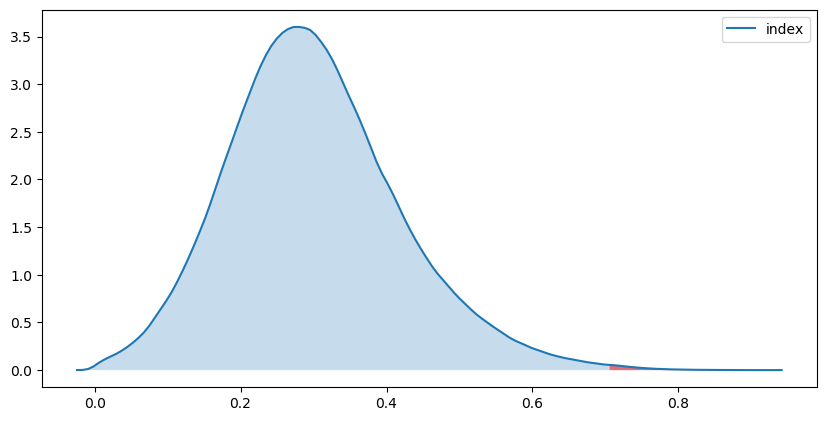

In [14]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

kde  = sns.kdeplot(group_coevol['index'], shade=True, ax=ax)

line = kde.get_lines()[-1]
x, y = line.get_data()
mask = x > 0.7
x, y = x[mask], y[mask]

ax.fill_between(x, y1=y, alpha=0.5, facecolor='red')

In [337]:
tmp_input_edges           = group_coevol.query('index >= 0.7').copy()
# tmp_input_edges['index'] -= 0.7

graph = ig.Graph.TupleList(edges   =tmp_input_edges[['group1', 
                                                     'group2', 
                                                     'index']].itertuples(index=False, 
                                                                          name =None), 
                           directed=False, 
                           weights =True)

random.seed(12345)
clusters                  = graph.community_multilevel(weights='weight')
graph.vs['louvain' ]      = clusters.membership
graph.vs['num_taxa']      = num_taxa.loc[graph.vs['name'], 'num_taxa'    ].tolist()
graph.vs['num_proteins']  = num_taxa.loc[graph.vs['name'], 'num_proteins'].tolist()
graph.vs['single_copy']   = [True 
                             if num_taxa.loc[node, 'num_taxa'] == num_taxa.loc[node, 'num_proteins'] 
                             else False
                             for node in graph.vs['name']]

# graph.write_picklez('coevolving_graph.pkl')

graph.modularity(graph.vs['louvain'], weights='weight')

0.32120600451857073

In [156]:
minimum_size_clusters

[3, 4, 2, 0, 5, 8, 1, 15]

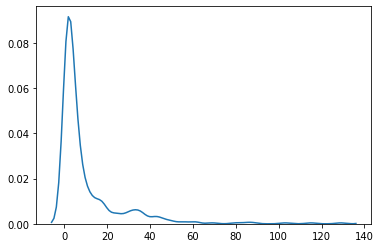

In [266]:
degree = np.array(graph.vs.degree())
kde = sns.kdeplot(degree)

In [282]:
percentile_80 = np.percentile(degree, 89)

sum(degree[degree <= percentile_80]), sum(degree[degree > percentile_80])

(2150, 2134)

In [283]:
sum(degree[degree > percentile_80]) / sum(degree[degree <= percentile_80])

0.9925581395348837

In [211]:
random.seed(12345)

edge_removal_clusters = []
while len(edge_removal_clusters) < 1_000:
    
    random_graph = deepcopy(graph)
    edges2remove = random.sample(range(2142), 214)
    random_graph.es[edges2remove].delete()

#     random_graph.es.delete()
#     bootstrapped_edges = random.choices(tmp_input_edges.index, k=graph.ecount())
#     random_graph.add_edges( tmp_input_edges.loc[bootstrapped_edges, 
#                                                 ['group1' ,'group2']].itertuples(index=False, 
#                                                                                  name =None) )    
#     random_graph.es['weight'] = tmp_input_edges.loc[bootstrapped_edges, 'index'].tolist()
    
    tmp_clusters = random_graph.community_multilevel(weights='weight')
    
    edge_removal_clusters.append( tmp_clusters.membership )

In [212]:
vi_distances = []
for clustering1, clustering2 in itertools.combinations(edge_removal_clusters, 2):
    vi_distances.append( ig.compare_communities(clustering1, clustering2) / np.log(419) )

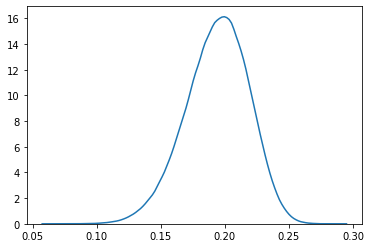

In [213]:
sns.kdeplot(vi_distances)

In [338]:
intra_cluster_degree  = pd.Series()
minimum_size_clusters = []
for clst_num, clst_size in Counter(graph.vs['louvain']).most_common():
    if clst_size < 10:
        continue
    print(clst_num, clst_size)
    minimum_size_clusters.append(clst_num)
    
    subg                 = graph.vs.select(louvain=clst_num).subgraph()
    intra_cluster_degree = intra_cluster_degree.append( pd.Series(index=subg.vs['name'], 
#                                                                   data =subg.strength(weights='weight')) )
                                                                  data =subg.degree()) )

3 111
4 62
2 47
0 35
5 28
8 18
1 15
15 15


In [316]:
for clst_num in minimum_size_clusters:
    clst_nodes = graph.vs.select(louvain=clst_num, single_copy=True, num_taxa_ge=35)
    if not clst_nodes:
        continue
        
    print(clst_num, len(clst_nodes))

3 27
4 44
2 13
5 18


In [339]:
graph.vs['degree']      = graph.degree()
graph.vs['clst_degree'] = intra_cluster_degree.reindex(index=graph.vs['name']).tolist()

clst_enrichment = pd.Series()
graph_size      = graph.vcount() - 1
auto_trust      = []
for clst_num in minimum_size_clusters:
    clst_nodes = graph.vs.select(louvain=clst_num)
    clst_size  = len(clst_nodes) - 1
    for node in clst_nodes:
#         if node['clst_degree'] >= node['degree'] * 0.9:
#             auto_trust.append(node['name'])
#             continue
            
        clst_enrichment[node['name']] = hypergeom.sf(node['clst_degree'] - 1, # successes in sample
                                                     graph_size,              # population size
                                                     clst_size,               # successes in population
                                                     node['degree'] )         # sample sizes

auto_trust.extend( graph.vs.select(louvain_notin=minimum_size_clusters)['name'] )

In [340]:
reject, correct_p, alphacSidak, alphaBonf = multipletests(clst_enrichment.values, alpha=0.1)
fdr_df = pd.DataFrame(columns=['trusted', 'corrected_pval', 'pval'],
                      index  =clst_enrichment.index,
                      data   =zip(reject, 
                                  correct_p,
                                  clst_enrichment.values))

fdr_df = fdr_df.append( pd.DataFrame(index  =auto_trust,
                                     columns=['trusted', 'corrected_pval', 'pval'],
                                     data   =None) )
fdr_df.loc[auto_trust, 'trusted'] = True

graph.vs['trusted_clst'] = fdr_df.loc[graph.vs['name'], 'trusted'].tolist()

In [455]:
for clst_num in minimum_size_clusters:
#     clst_nodes = graph.vs.select(louvain=clst_num)
    print(clst_num, 
          len(graph.vs.select(louvain=clst_num)),
          len(graph.vs.select(louvain=clst_num, single_copy=True)),
          len(graph.vs.select(louvain=clst_num, single_copy=True, num_taxa_ge=35)),
#           len(graph.vs.select(louvain=clst_num, trusted_clst=True))
         )

3 111 66 27
4 62 49 44
2 47 34 13
0 35 27 0
5 28 21 18
8 18 15 0
1 15 15 0
15 15 15 0


In [471]:
core_subg     = deepcopy(graph.vs.select(single_copy=True, num_taxa_ge=35).subgraph())
core_subg.vs['degree'] = core_subg.degree()
cluster4_core = core_subg.vs.select(louvain=4)
other_core    = core_subg.vs.select(louvain_ne=4)

In [458]:
len(cluster4_core), len(other_core)

(44, 58)

In [478]:
mannwhitneyu(other_core['degree'], cluster4_core['degree'])

MannwhitneyuResult(statistic=613.5, pvalue=3.7839247759311307e-06)

In [483]:
cles(other_core['degree'], cluster4_core['degree'])

0.7488244514106583

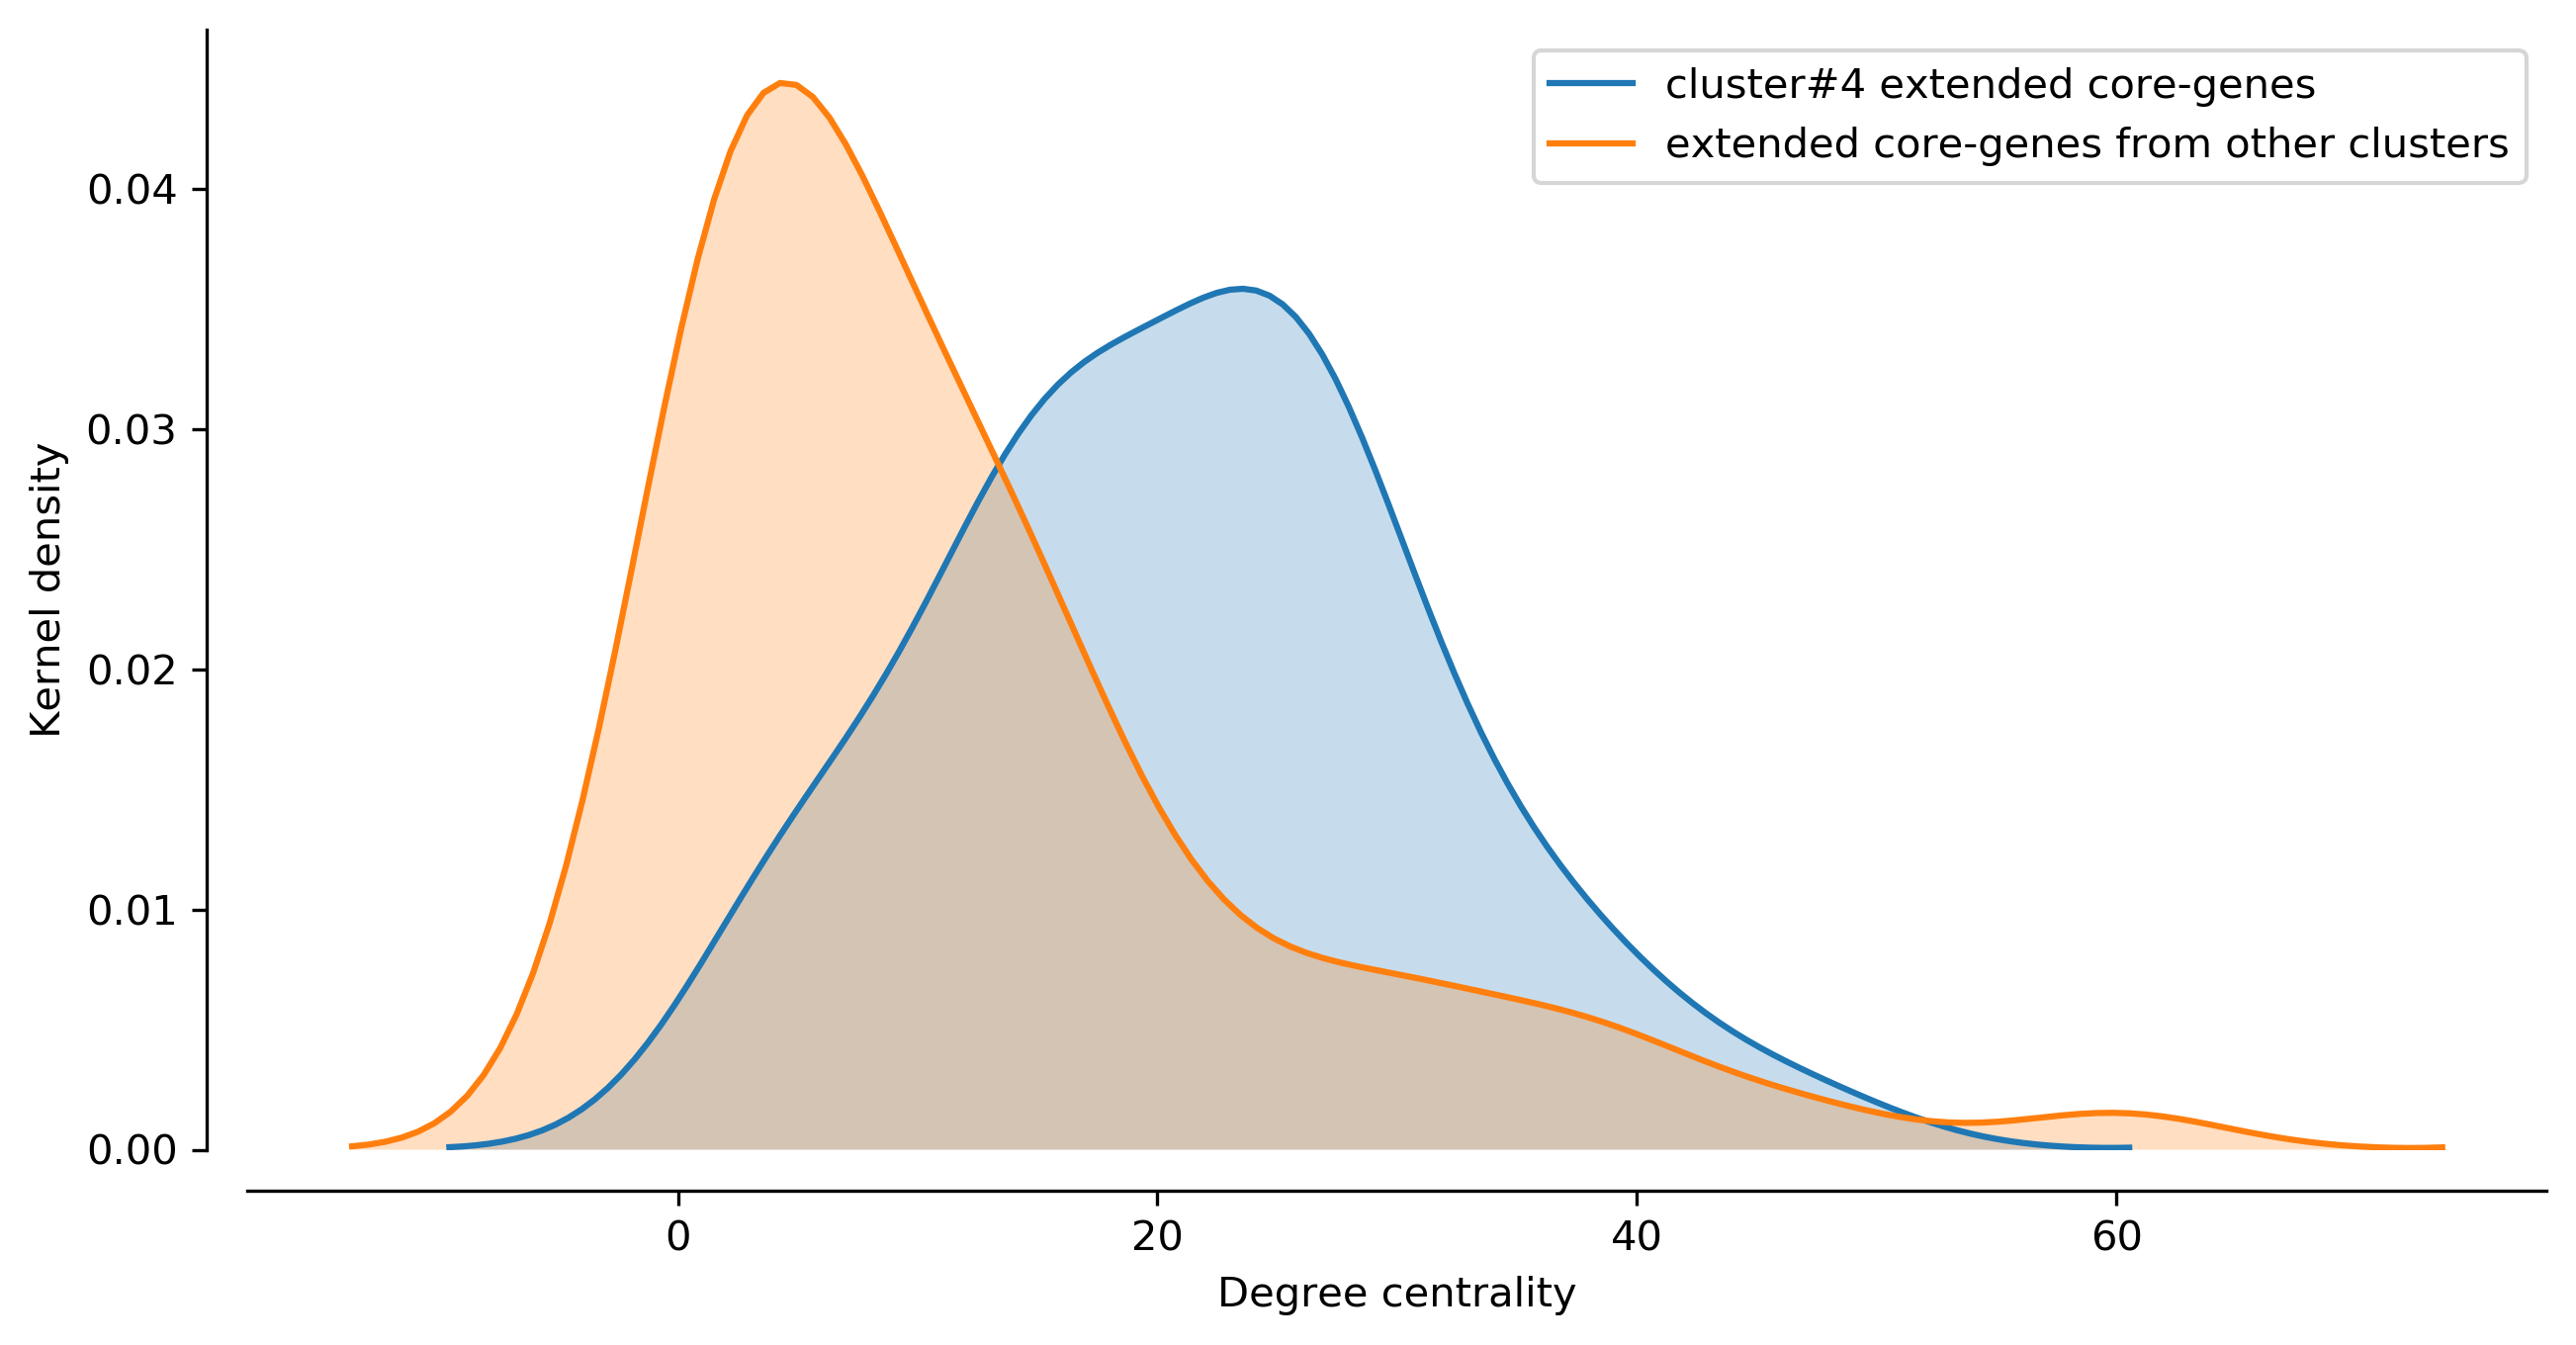

In [484]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

sns.kdeplot(cluster4_core['degree'], 
            label='cluster#4 extended core-genes', 
            shade=True, 
            ax=ax)
sns.kdeplot(other_core['degree'], 
            label='extended core-genes from other clusters', 
            shade=True, 
            ax=ax)

ax.set_xlabel('Degree centrality')
ax.set_ylabel('Kernel density')

sns.despine(offset=10)

In [ ]:
# %%time

# random.seed(12345)

# clst_robustness_graph = deepcopy(graph)
# clst_robustness_graph.es.delete()

# count = 0
# while count < 100:
#     count    += 1
#     tmp_graph = deepcopy(graph)
    
#     tmp_graph.delete_edges( random.sample(tmp_graph.es.indices, 
#                                           int(graph.ecount() * 0.1)) )
#     tmp_clustering = tmp_graph.community_multilevel(weights='weight')
#     clst_robustness_graph.vs['tmp_cluster'] = tmp_clustering.membership
    
#     for clst_num in set(tmp_clustering.membership):
#         tmp_nodes = clst_robustness_graph.vs.select(tmp_cluster=clst_num)
#         clst_robustness_graph.add_edges( tuple(itertools.combinations(tmp_nodes, 
#                                                                       2)) )

# clst_robustness_graph.ecount()

In [ ]:
# random.seed(12345)
# Manager            = multiprocessing.Manager()
# clustered_together = Manager.list()

# def bootstrap_edges(loop_count=None):
#     tmp_graph = deepcopy(graph)
#     num_edges = tmp_graph.ecount()
#     tmp_graph.es.delete()
    
#     bootstrapped_edges = random.choices(tmp_input_edges.index, 
#                                         k=num_edges)
#     tmp_graph.add_edges(tmp_input_edges.loc[bootstrapped_edges, 
#                                            ['group1', 
#                                             'group2']].itertuples(index=False, 
#                                                                   name =None))
#     tmp_graph.es['weight'] = tmp_input_edges.loc[bootstrapped_edges, 
#                                                  'index'].tolist()
#     tmp_graph.simplify(combine_edges=sum);
        
#     tmp_clustering              = tmp_graph.community_multilevel(weights='weight')
#     tmp_graph.vs['tmp_cluster'] = tmp_clustering.membership
    
#     tmp_edges = []
#     for clst_num in set(tmp_graph.vs['tmp_cluster']):
#         tmp_nodes = tmp_graph.vs.select(tmp_cluster=clst_num)['name']
#         tmp_edges.extend( list(itertools.combinations(tmp_nodes, 
#                                                       2)) )
    
#     clustered_together.extend(tmp_edges)
#     return(loop_count)

# def random_edge_removal(loop_count=None, ratio_to_remove=0.1):
#     tmp_graph = deepcopy(graph)
#     num_edges = tmp_graph.ecount()
    
#     num_edges_to_remove = int(num_edges * ratio_to_remove)
    
#     tmp_graph.delete_edges( random.sample(tmp_graph.es.indices, 
#                                           num_edges_to_remove) )
#     tmp_graph.vs['tmp_cluster'] = tmp_graph.community_multilevel(
#         weights='weight'
#     ).membership
    
#     tmp_edges = []
#     for clst_num in set(tmp_graph.vs['tmp_cluster']):
#         tmp_nodes = tmp_graph.vs.select(tmp_cluster=clst_num)['name']
#         tmp_edges.extend( list(itertools.combinations(tmp_nodes, 
#                                                       2)) )
    
#     clustered_together.extend(tmp_edges)
#     return(loop_count)

In [ ]:
# %%time

# jackknife_count = 1_00
# pool            = multiprocessing.Pool(processes=15)
# # ran_loops       = pool.map(bootstrap_edges, range(jackknife_count))
# ran_loops       = pool.map(random_edge_removal, range(jackknife_count))
# pool.close()
# pool.join()

# clst_robustness_graph = deepcopy(graph)
# clst_robustness_graph.es.delete()

# clst_robustness_graph.add_edges(clustered_together)
# clst_robustness_graph.ecount()

In [ ]:
# minimum_size_clusters = [clst_num
#                          for clst_num, clst_size in Counter(clusters.membership).most_common()
#                          if clst_size > 10]

# for clst_num in minimum_size_clusters[:]:
#     clst_subgraph   = deepcopy(
#         clst_robustness_graph.vs.select(louvain=clst_num).subgraph()
#     )

#     max_frequency   = jackknife_count * (clst_subgraph.vcount() - 1)
#     obs_frequencies = np.array(clst_subgraph.degree())
    
#     clst_subgraph.vs['cluster_confidence'] = obs_frequencies / max_frequency
    
#     low_confidence  = clst_subgraph.vs.select(cluster_confidence_lt=0.4)['name']
#     high_confidence = clst_subgraph.vs.select(cluster_confidence_ge=0.4)['name']

#     graph.vs.select(name_in=low_confidence)['louvain'] = -1
#     print(clst_num, clst_subgraph.vcount(), len(high_confidence))

# graph.write_picklez('coevolving_graph.pkl')

In [42]:
graph.write_picklez('coevolving_graph.pkl')

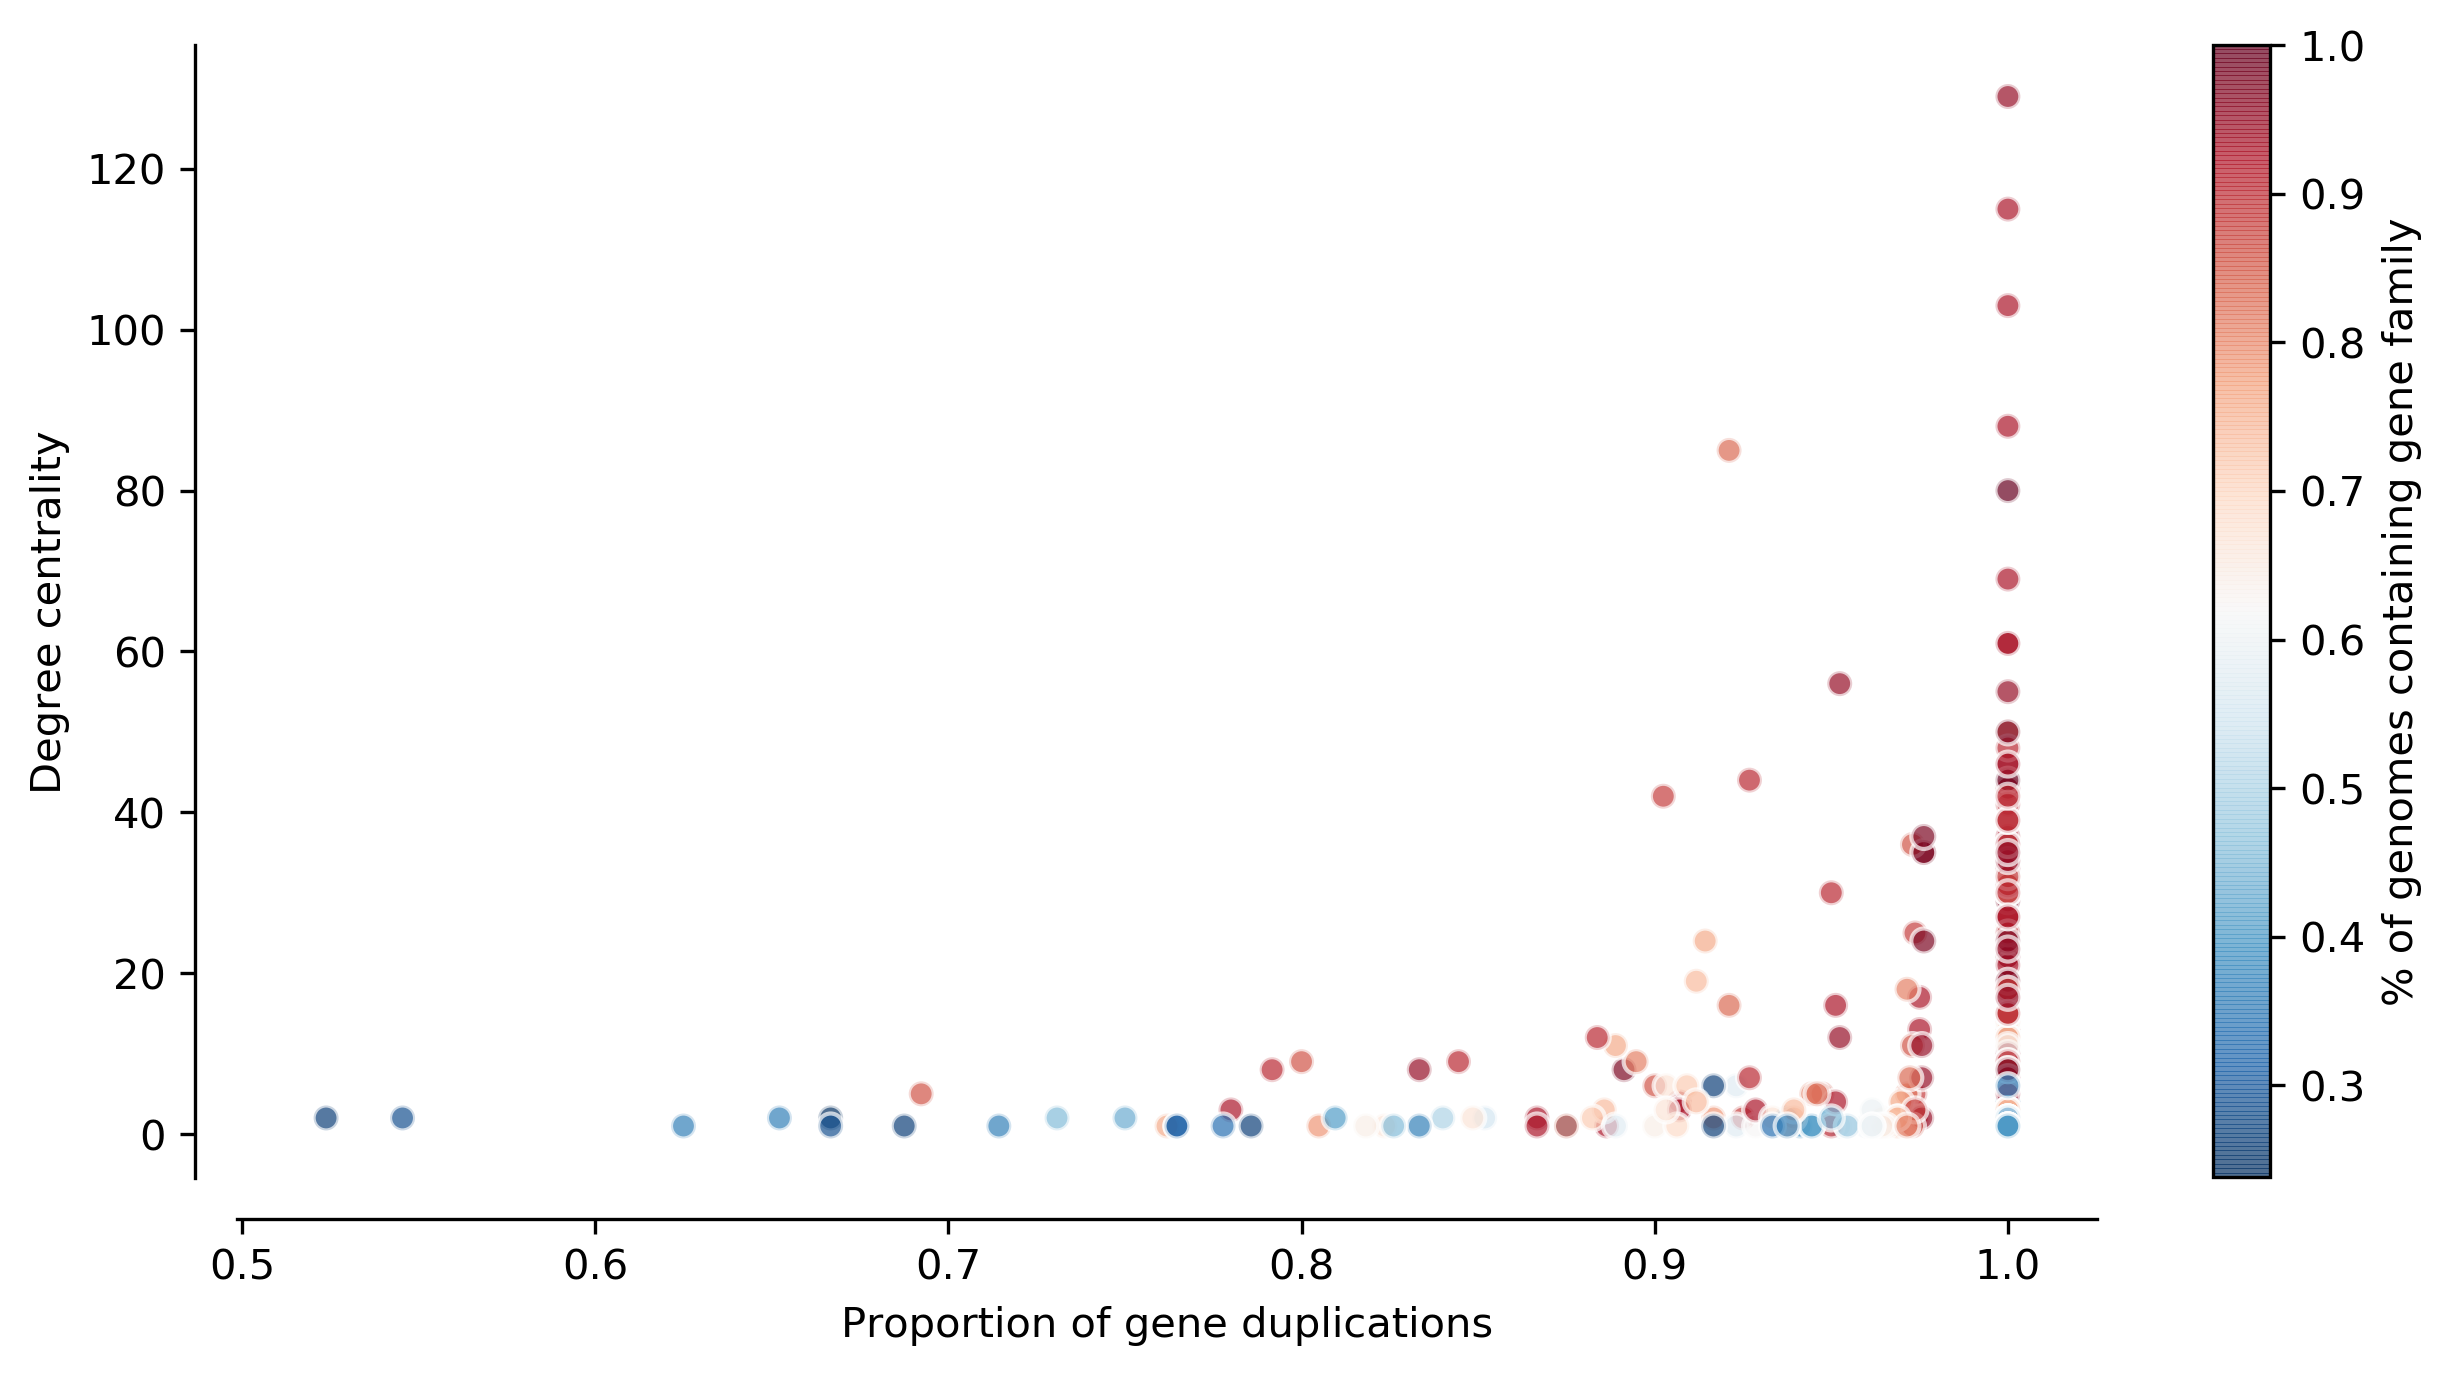

In [482]:
fig, ax = plt.subplots(figsize=(10,5), dpi=300)

datapoints = ax.scatter([node['num_taxa']/node['num_proteins']
                         for node in graph.vs], 
                        graph.vs['degree'],
                        c        =np.array(graph.vs['num_taxa'])/42,
                        alpha    =0.7,
                        cmap     ='RdBu_r',
                        edgecolor='white')

cbar = fig.colorbar(datapoints)
cbar.set_label('% of genomes containing gene family')

ax.set_xlabel('Proportion of gene duplications')
ax.set_ylabel('Degree centrality')

sns.despine(offset=10)

In [44]:
for clst_num in minimum_size_clusters:
    clst_nodes = graph.vs.select(louvain=clst_num, trusted_clst=True)
    
    print( clst_num, len(clst_nodes), len(core_genes.intersection(clst_nodes['name'])) )

3 12 6
4 48 39
2 6 1
0 17 0
5 20 16
8 13 0
1 11 0
15 3 0


In [346]:
cluster_count = len(minimum_size_clusters)
tmp_colors    = [_.replace(')', ',0.7)') for _ in cl.scales[str(cluster_count)]['qual']['Set2']]
cluster_color = dict( zip(minimum_size_clusters,
                          tmp_colors) )
# graph.vs['color'] = [cluster_color[node['louvain']] if node['louvain'] in cluster_color and node['trusted_clst']
graph.vs['color'] = [cluster_color[node['louvain']] if node['louvain'] in cluster_color
                     else 'rgb(0,0,0,0.5)' 
                     for node in graph.vs]

print(
    ', '.join([str(len( graph.vs.select(louvain=clst_num, 
                                        trusted_clst=True) )) 
               for clst_num in minimum_size_clusters])
)
HTML(cl.to_html( tmp_colors ))

12, 48, 6, 17, 20, 13, 11, 3


In [343]:
minimum_size_clusters

[3, 4, 2, 0, 5, 8, 1, 15]

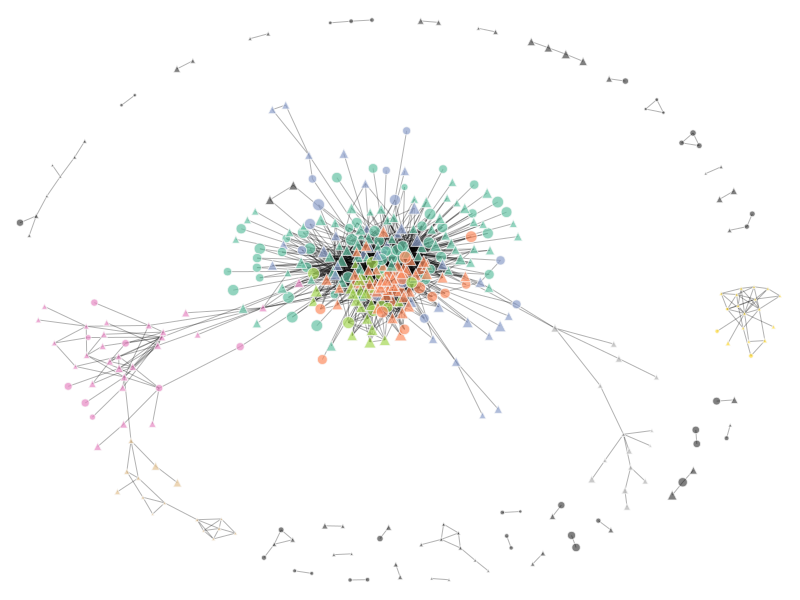

In [485]:
graph_layout  = graph.layout(layout='auto')

ig.plot(graph, 
        layout            =graph_layout,
        vertex_color      =graph.vs['color'], 
        vertex_frame_color='rgb(250,250,250,0.7)',
        vertex_size       =0.3 * np.array(graph.vs['num_taxa']), 
        vertex_shape      =['circle' if not single_copy
                            else 'triangle-up'
                            for single_copy in graph.vs['single_copy']],
        edge_color        ='rgb(0,0,0,0.3)', 
        bbox              =(800, 600), 
#         scale             =0.1,
)

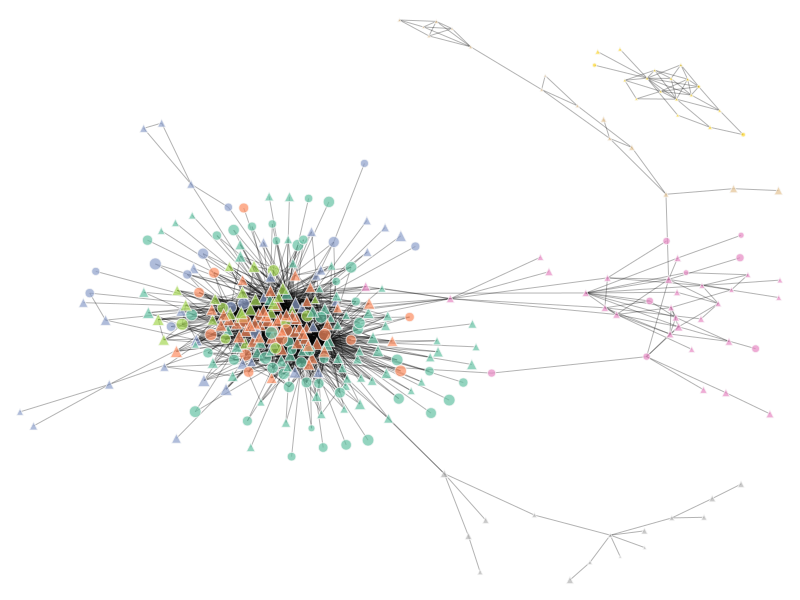

In [486]:
graph_to_plot = graph.vs.select(louvain_in=minimum_size_clusters).subgraph()
graph_layout  = graph_to_plot.layout(layout='auto')

ig.plot(graph_to_plot, 
        layout            =graph_layout,
        vertex_color      =graph_to_plot.vs['color'], 
        vertex_frame_color='rgb(250,250,250,0.7)',
        vertex_size       =0.3 * np.array(graph_to_plot.vs['num_taxa']), 
        vertex_shape      =['circle' if not single_copy
                            else 'triangle-up'
                            for single_copy in graph_to_plot.vs['single_copy']],
        edge_color        ='rgb(0,0,0,0.3)', 
        bbox              =(800, 600), 
        dpi               =300
#         scale             =0.1,
)

3 0.4365079365079365
4 0.5648148148148148
2 0.3511450381679389
0 0.35051546391752575
5 0.5455102040816326
8 0.5075757575757576
1 0.358974358974359
15 0.35
core_gene 0.2009952238758683


/home/thiberio/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: closeness centrality is not well-defined for disconnected graphs at /tmp/pip-req-build-_50os74k/vendor/source/igraph/src/centrality.c:2856
  # This is added back by InteractiveShellApp.init_path()


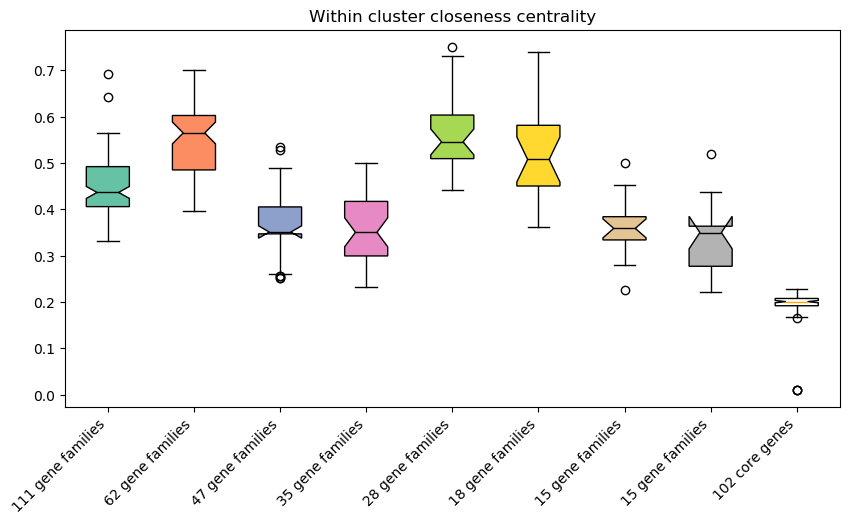

In [397]:
cluster_closeness = []
for clst_num in minimum_size_clusters:    
    clst_nodes    = graph.vs.select(louvain=clst_num)
    clst_subgraph = clst_nodes.subgraph()
    cluster_closeness.append(clst_subgraph.closeness(normalized=True))
    
    print(clst_num, np.median(cluster_closeness[-1]))

clst_nodes    = graph.vs.select(name_in=core_genes)
clst_subgraph = clst_nodes.subgraph()
cluster_closeness.append(clst_subgraph.closeness(normalized=True))
print('core_gene', np.median(cluster_closeness[-1]))

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.set_title('Within cluster closeness centrality')

bplot = ax.boxplot(cluster_closeness, 
                   patch_artist=True,
                   notch       =True,
                   medianprops =dict(color='#000000'),
);

for patch, color in zip(bplot['boxes'], tmp_colors):
    r, g, b     = [int(_) for _ in re.match('rgb\((\d+),(\d+),(\d+)', color).groups()]
    patch.set_facecolor('#%2x%2x%2x' % (r, g, b))
bplot['boxes'][  -1].set_facecolor('#FFFFFF')
bplot['medians'][-1].set_color('orange')

# xticks = [f'{ len(graph.vs.select(louvain=clst_num, trusted_clst=True)) } gene families' 
xticks = [f'{ len(graph.vs.select(louvain=clst_num)) } gene families' 
          for clst_num in minimum_size_clusters]

clst_nodes    = graph.vs.select(name_in=core_genes)
xticks.append(f'{len(clst_nodes)} core genes')

ax.set_xticklabels(xticks, rotation=45, ha='right');

3 0.019785446722459667
4 0.19539936963153373
2 0.03139935393795843
0 0.04465733534679044
5 0.18146525625886892
8 0.16593057953065068
1 0.14742930553894315
15 0.05061423918355583


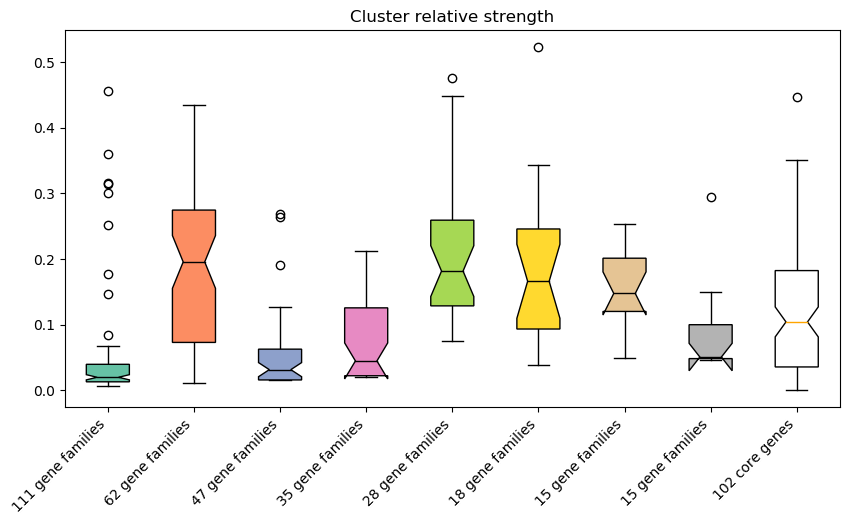

In [396]:
cluster_strengths = []
cluster_degrees   = []
for clst_num in minimum_size_clusters:    
#     clst_nodes    = graph.vs.select(louvain=clst_num, trusted_clst=True)
    clst_nodes    = graph.vs.select(louvain=clst_num)
    clst_subgraph = clst_nodes.subgraph()
    
    tmp_strenghts = np.array(clst_subgraph.strength(weights='weight'))
    cluster_strengths.append(tmp_strenghts / clst_subgraph.vcount())
    cluster_degrees.append(  clst_subgraph.degree())
    
    print(clst_num, np.median(cluster_strengths[-1]))

clst_nodes    = graph.vs.select(name_in=core_genes)
clst_subgraph = clst_nodes.subgraph()
tmp_strenghts = np.array(clst_subgraph.strength(weights='weight'))
cluster_strengths.append(tmp_strenghts / clst_subgraph.vcount())
cluster_degrees.append(  clst_subgraph.degree())

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.set_title('Cluster relative strength')

bplot = ax.boxplot(cluster_strengths, 
                   patch_artist=True,
                   notch       =True,
                   medianprops =dict(color='#000000'),
);

for patch, color in zip(bplot['boxes'], tmp_colors):
    r, g, b     = [int(_) for _ in re.match('rgb\((\d+),(\d+),(\d+)', color).groups()]
    patch.set_facecolor('#%2x%2x%2x' % (r, g, b))
bplot['boxes'][  -1].set_facecolor('#FFFFFF')
bplot['medians'][-1].set_color('orange')

# xticks = [f'{ len(graph.vs.select(louvain=clst_num, trusted_clst=True)) } gene families' 
xticks = [f'{ len(graph.vs.select(louvain=clst_num)) } gene families' 
          for clst_num in minimum_size_clusters]

clst_nodes    = graph.vs.select(name_in=core_genes)
xticks.append(f'{len(clst_nodes)} core genes')

ax.set_xticklabels(xticks, rotation=45, ha='right');

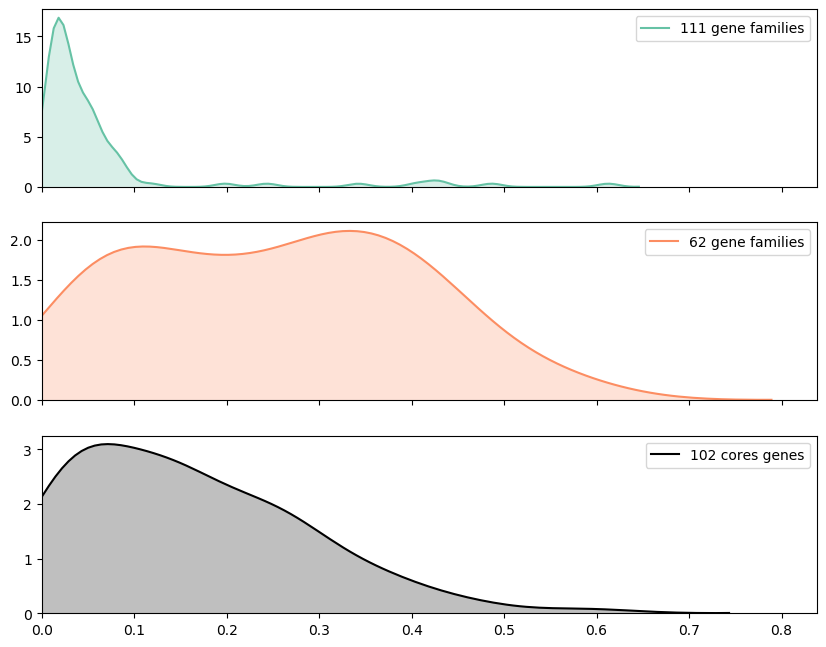

In [335]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(10, 8), dpi=100)

# clst_nodes       = graph.vs.select(louvain=3, trusted_clst=True)
clst_nodes       = graph.vs.select(louvain=3)
clst_subgraph    = clst_nodes.subgraph()
r, g, b          = [int(_) 
                    for _ in re.match('rgb\((\d+),(\d+),(\d+)', 
                                      tmp_colors[0]).groups()]
sns.kdeplot(np.array(clst_subgraph.degree()) / clst_subgraph.vcount(), 
            shade=True, 
            color='#%2x%2x%2x' % (r, g, b),
            label=f'{ len(clst_nodes) } gene families',
            ax   =axs[0])

#########################################################################
# clst_nodes       = graph.vs.select(louvain=4, trusted_clst=True)
clst_nodes       = graph.vs.select(louvain=4)
clst_subgraph    = clst_nodes.subgraph()
r, g, b          = [int(_) 
                    for _ in re.match('rgb\((\d+),(\d+),(\d+)', 
                                      tmp_colors[1]).groups()]
sns.kdeplot(np.array(clst_subgraph.degree()) / clst_subgraph.vcount(), 
            shade=True, 
            color='#%2x%2x%2x' % (r, g, b),
            label=f'{ len(clst_nodes) } gene families',
            ax   =axs[1])

#########################################################################
core_nodes    = graph.vs.select(name_in=core_genes)
core_subgraph = core_nodes.subgraph()
sns.kdeplot(np.array(core_subgraph.degree()) / core_subgraph.vcount(), 
            shade=True, 
            color='#000000',
            label=f'{ len(core_nodes) } cores genes',
            ax=axs[2]);

axs[0].set_xlim(left=0);

In [28]:
def get_taxa(group_name, matrix):
    taxa = set([taxon.split('|')[0] for taxon in matrix.index])
    return( group_name, taxa )

group_taxa = pd.DataFrame(columns=['group_num', 'taxa'],
                          data   =[get_taxa(group, table[str(group)]) for group in graph.vs['name']])
group_taxa.set_index('group_num', inplace=True)

all_genomes = set().union(*group_taxa.taxa.values)

In [326]:
taxon_occurrences = pd.DataFrame(columns=all_genomes)
for clst_num in minimum_size_clusters:
        
#     group_names = graph.vs.select(louvain=clst_num, trusted_clst=True)['name']
    group_names = graph.vs.select(louvain=clst_num)['name']
    taxa_concat = list(itertools.chain(*group_taxa.loc[group_names, 'taxa'].tolist()))
    taxon_freq  = pd.Series(Counter(taxa_concat)) / len(group_names)
    
#     taxon_freq.name = f'cluster_{clst_num}'
    taxon_freq.name = clst_num
    
    taxon_occurrences = taxon_occurrences.append(taxon_freq)
    
taxon_occurrences[taxon_occurrences.isna()] = 0

In [327]:
tmp = group_taxa.reindex(index=core_genes)
tmp.dropna(inplace=True)

taxa_concat     = list( itertools.chain(*tmp.taxa.tolist()) )
taxon_freq      = pd.Series(Counter(taxa_concat)) / tmp.shape[0]
taxon_freq.name = f'core genes'

taxon_occurrences = taxon_occurrences.append(taxon_freq)

In [31]:
header = 'assembly_accession bioproject biosample wgs_master refseq_category taxid species_taxid \
          organism_name infraspecific_name isolate version_status assembly_level release_type \
          genome_rep seq_rel_date asm_name submitter gbrs_paired_asm paired_asm_comp ftp_path \
          excluded_from_refseq relation_to_type_material'.split()

genbank_summary = pd.read_csv('~/work/assembly_summary_genbank.txt', 
                              sep      ='\t', 
                              index_col=0, 
                              header   =None, 
                              names    =header, 
                              comment  ='#')
genbank_summary = genbank_summary.reindex(index=all_genomes).copy()

In [328]:
lineages = pd.DataFrame()
for taxid in genbank_summary.taxid.unique():
    try:
        taxid_lineage = ncbi.get_lineage(int(taxid))
    except ValueError:
        missing_taxids.add(taxid)
    else:
        tmp_lineage = pd.Series( {rank:taxon
                                  for taxon, rank in ncbi.get_rank( taxid_lineage ).items()} )
        tmp_lineage.name = taxid
        lineages    = lineages.append(tmp_lineage)

lineages.drop(columns='no rank', inplace=True)

In [329]:
genome_taxonomy = pd.Series()
for genome, row in genbank_summary.iterrows():
    tmp_lineage = lineages.loc[row.taxid]
    if tmp_lineage.clade == 1935183:
        genome_taxonomy[genome] = 'Asgard group'
    else:
        genome_taxonomy[genome] = ncbi.translate_to_names([tmp_lineage.phylum])[0]

In [330]:
phylum_colors = {}
for taxon, color in zip(genome_taxonomy.unique(),
                         cl.scales[str(genome_taxonomy.unique().shape[0])]['qual']['Set2']):
    
    r, g, b     = [int(_) for _ in re.match('rgb\((\d+),(\d+),(\d+)\)', color).groups()]
    
    genomes = genome_taxonomy[genome_taxonomy==taxon].index
    for genome in genomes:
        phylum_colors[genome] = '#%02x%02x%02x' % (r, g, b)
#         phylum_colors[genome] = '#000000'
#     break

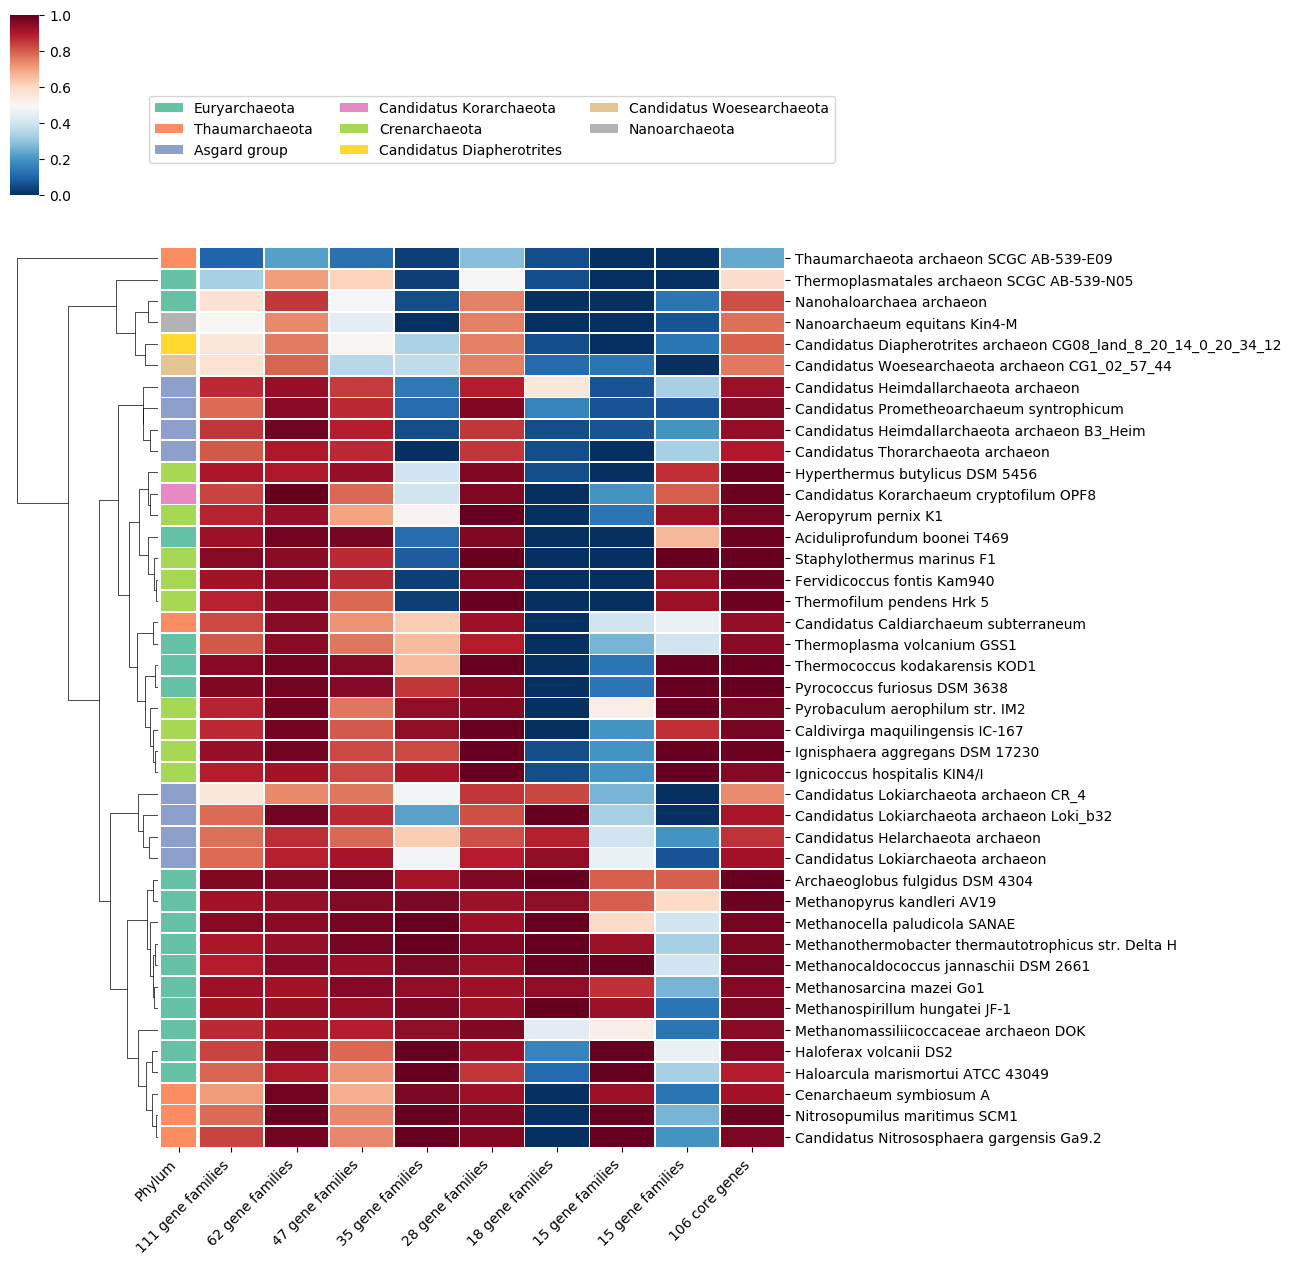

In [331]:
tmp        = taxon_occurrences.T.copy()
row_colors = pd.Series(index=tmp.index, 
                       data=tmp.index.map(phylum_colors), 
                       name='Phylum')

tmp.rename(index  =genbank_summary.organism_name, 
#            columns={column:f'{ len(graph.vs.select(louvain=column, trusted_clst=True)) } gene families' if type(column) is int 
           columns={column:f'{ len(graph.vs.select(louvain=column)) } gene families' if type(column) is int 
                    else f'{ len(core_genes) } core genes'
                    for column in tmp.columns},
           inplace=True)
row_colors.rename(genbank_summary.organism_name, 
                  inplace=True)

clst_map = sns.clustermap(tmp, 
                          method='complete', 
                          metric='braycurtis',
                          col_cluster=False,
                          cmap='RdBu_r', 
                          linewidth=0.5,
                          row_colors=row_colors,
                         );

added_clades = []
for genome, color in phylum_colors.items():

    clade_name  = genome_taxonomy[genome] 
    if clade_name not in added_clades:
        added_clades.append(clade_name)
    else:
        continue

    clst_map.ax_col_dendrogram.bar(0, 0, 
                                   color    =color,
                                   label    =clade_name, 
                                   linewidth=0)
clst_map.ax_col_dendrogram.legend(loc="center", ncol=3)
# clst_map.cax.set_position([.15, .2, .03, .45])

clst_map.ax_heatmap.set_xticklabels(clst_map.ax_heatmap.get_xticklabels(), 
                                    rotation=45, 
                                    ha='right')
clst_map.ax_row_colors.set_xticklabels(clst_map.ax_row_colors.get_xticklabels(), 
                                       rotation=45, 
                                       ha='right')

clst_map.fig.set_size_inches(10, 15)
clst_map.fig.set_dpi(100);

In [333]:
taxon_occurrences.index

Index([3, 4, 2, 0, 5, 8, 1, 15, 'core genes'], dtype='object')

In [ ]:
def concate_genes(group_numbers, clst_num, target_folder):

    concat_genomes = set().union(*group_taxa.loc[group_numbers, 'taxa'].values)
    
    missing_genes = {} # just to keep track of the number of missing marker genes in each genome
    concatenation = {}
    for genome in concat_genomes:
        missing_genes[genome]             = 0
        concatenation[genome]             = Align.SeqRecord( Align.Seq('', aln_alphabet) )
        concatenation[genome].name        = genome
        concatenation[genome].id          = genome
        concatenation[genome].description = genome
    
    total_genes      = 0.0 # keep track of the number of genes added to the concatenation
    current_position = 1
    aln_folder       = 'alignments/'
    partitions       = open(f'{target_folder}/core_genes_from_cluster_{clst_num}', 'w')
    for group_num in group_numbers:

        tmp_aln      = AlignIO.read( f'{aln_folder}/{group_num}.aln', 'fasta' )
        aln_length   = tmp_aln.get_alignment_length() # get the expected size of the alignment so you can compare if all have the same size
        total_genes += aln_length

        genomes_found = set()
        for entry in tmp_aln:
            # if this alignment has a different size from the rest, something is reaaaaaly wrong!
            if len(entry) != aln_length:
                print('\t**Error, block "%s" has a different length than the rest of the MSA: %s' %(entry.name, aln))

            protein, genome = entry.name.split('|')
            
            concatenation[genome] += deepcopy(entry.seq)
            genomes_found.add(genome)

        partition_name = f'cluster{group_num}'
        partitions.write(f'LG, {partition_name} = {current_position}-{current_position+aln_length-1}\n')
        current_position += aln_length

        #
        # add gaps for those genomes missing this gene (same size as the expected alignment)
        for genome in concat_genomes.difference(genomes_found):
            concatenation[genome] += Align.Seq( '-' * aln_length, aln_alphabet )
            missing_genes[genome] += aln_length
    partitions.close()

    AlignIO.write( Align.MultipleSeqAlignment( concatenation.values() ), 
                  f'{target_folder}/core_genes_from_cluster_{clst_num}.aln', 'fasta' )

In [ ]:
core_subg = graph.vs.select(name_in=core_genes).subgraph()

for clst_num in set( core_subg.vs['louvain'] ):
    
    clst_nodes = core_subg.vs.select(louvain=clst_num)
    concate_genes(clst_nodes['name'], clst_num, 'single_copy_phylogenies')

In [ ]:
concate_genes(core_subg.vs['name'], 'all', 'single_copy_phylogenies')

In [ ]:
for clst_num in set( core_subg.vs['louvain'] ):
    
    with open(f'single_copy_phylogenies/core_genes_from_cluster_{clst_num}.treefile') as tree_handle:
        newick  = tree_handle.read()
        
    for index, row in genbank_summary.iterrows():
        newick = newick.replace(index, 
                                str(row.taxid))
    
    with open(f'single_copy_phylogenies/core_genes_from_cluster_{clst_num}.taxid.treefile', 'w') as tree_handle:
        tree_handle.write(newick)

In [ ]:
with open(f'single_copy_phylogenies/core_genes_from_cluster_all.treefile') as tree_handle:
    newick  = tree_handle.read()

for index, row in genbank_summary.iterrows():
    newick = newick.replace(index, 
                            str(row.taxid))

with open(f'single_copy_phylogenies/core_genes_from_cluster_all.taxid.treefile', 'w') as tree_handle:
    tree_handle.write(newick)

In [ ]:
for clst_num in set( core_subg.vs['louvain'] ):
    
    with open(f'single_copy_phylogenies/core_genes_from_cluster_{clst_num}-C20.treefile') as tree_handle:
        newick  = tree_handle.read()
        
    for index, row in genbank_summary.iterrows():
        newick = newick.replace(index, 
                                str(row.taxid))
    
    with open(f'single_copy_phylogenies/core_genes_from_cluster_{clst_num}-C20.taxid.treefile', 'w') as tree_handle:
        tree_handle.write(newick)

In [ ]:
with open(f'single_copy_phylogenies/core_genes_from_cluster_all-C20.treefile') as tree_handle:
    newick  = tree_handle.read()

for index, row in genbank_summary.iterrows():
    newick = newick.replace(index, 
                            str(row.taxid))

with open(f'single_copy_phylogenies/core_genes_from_cluster_all-C20.taxid.treefile', 'w') as tree_handle:
    tree_handle.write(newick)